# Public space classifier algorithm

Development notebook for a public space algorithm using machine learning and satellite, census and point of interest data.

## Import libraries

In [44]:
# data treatment and analysis
import geopandas as gpd
import pandas as pd
import numpy as np
import odc
# visual representation
import matplotlib.pyplot as plt
import seaborn as sns
# machine learning algorithms
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE

# from tensorflow.python.keras.models import Sequential
# from tensorflow.python.keras.layers import Dense
# from scikeras.wrappers import KerasClassifier, KerasRegressor

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV 
import xgboost as xgb
import random
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, mean_squared_error

## Data download and preprocessing

### Public space data

#### CDMX

In [3]:
schema = 'espacios_publicos'
table = 'ep_cdmx'
ep_cdmx = odc.gdf_from_db(table,schema)
print(ep_cdmx.shape)
ep_cdmx.head(2)

(11609, 13)


,id,geo_point_2d,geo_shape,subcat_sed,subcve_sed,gid,cve_delg,delegacion,categoria,superficie,perimetro,cve_sedema,geometry
0,0,"19.4877568178,-99.2060645931","{'type': 'MultiPolygon', 'coordinates': [[[[-9...",Panteones,604,268,2,Azcapotzalco,Equipamientos urbanos con vegetación,6660.027554,329.264738,600,"POLYGON ((-99.20639 19.48819, -99.20556 19.487..."
1,1,"19.3887689803,-99.116393168","{'type': 'MultiPolygon', 'coordinates': [[[[-9...",Deportivos,601,87,8,Iztacalco,Equipamientos urbanos con vegetación,2917.257837,272.2436142,600,"POLYGON ((-99.11679 19.38904, -99.11637 19.388..."


Filter data

In [4]:
ep_cdmx.subcat_sed.unique()

array(['Panteones', 'Deportivos', 'Camellones centrales y laterales',
       'Unidades habitacionales', 'Instituciones académicas públicas',
       'Plazas', 'Asistencia Social con vegetación CDMX', 'Parques',
       'Veg. Arbórea, arbustiva y herbácea de glorietas', 'Vialidades',
       'Instituciones académicas privadas', 'Arboledas',
       'Instituciones de salud pub/priv', 'Jardines públicos', 'Canales',
       'Jardineras públicas y privadas', 'Azoteas verdes', 'Bordos',
       'Terrenos baldíos', 'AVA', 'Depresiones orográficas', 'ANP',
       'Alamedas', 'Promontorios', 'Colinas', 'Cerros',
       'Zona de recarga de manto acuíferos'], dtype=object)

In [5]:
ep_cdmx = ep_cdmx[ep_cdmx['subcat_sed'].isin(['Deportivos','Plazas','Parques',
                                     'Arboledas','Jardines públicos','Jardineras públicas y privadas',
                                     'ANP','Alamedas'])]
print(ep_cdmx.shape)

(2427, 13)


#### AMG

In [6]:
schema = 'espacios_publicos'
table = 'ep_amg'
ep_amg = odc.gdf_from_db(table,schema)
print(ep_amg.shape)
ep_amg.head(2)

(8499, 4)


,Fuente,Tipo,Uso,geometry
0,"OpenStreetMap, [Online]. Disponible: http://ww...",Parque,Uso recreativo,"POLYGON ((672507.028 2272132.201, 672520.126 2..."
1,"OpenStreetMap, [Online]. Disponible: http://ww...",Parque,Uso recreativo,"POLYGON ((672520.126 2272170.353, 672507.028 2..."


Filter data

In [7]:
ep_amg = ep_amg.loc[ep_amg.Uso=='Uso recreativo'].copy()
print(ep_amg.shape)

(2999, 4)


#### Merge public space data

In [8]:
ep_amg = ep_amg.to_crs("EPSG:4326")
ep_cdmx = ep_cdmx.to_crs("EPSG:4326")

In [9]:
ep_gdf = pd.concat([ep_amg, ep_cdmx])
ep_gdf = ep_gdf[['Tipo','subcat_sed','geometry']].copy()
ep_gdf = ep_gdf.dissolve().explode()
print(ep_gdf.shape)
ep_gdf.head()

(5387, 3)


,Tipo,subcat_sed,geometry
0,Parque,Deportivos,"POLYGON ((-103.46681 20.51919, -103.46679 20.5..."
0,Parque,Deportivos,"POLYGON ((-103.46788 20.52087, -103.46792 20.5..."
0,Parque,Deportivos,"POLYGON ((-103.46391 20.52197, -103.46395 20.5..."
0,Parque,Deportivos,"POLYGON ((-103.46704 20.52207, -103.46741 20.5..."
0,Parque,Deportivos,"POLYGON ((-103.46696 20.52669, -103.46764 20.5..."


#### Delete individual GeoDataFrames

In [10]:
del ep_cdmx
del ep_amg

### Hexagon area of analysis

Filter urban hexagons for both cities

In [11]:
hex_schema = "hexgrid"

res = 11

hex_table = f"hexgrid_{res}_city_2020"

c1 = 'Guadalajara'
c2 ='CDMX'
type_area = 'urban'


query = f"""
SELECT h1.hex_id_{res}, h1.geometry, h1.city, h1.type
FROM {hex_schema}.{hex_table} h1
WHERE h1.city IN ('{c1}', '{c2}') AND h1.type = '{type_area}'
"""
hex_gdf = odc.gdf_from_query(query, geometry_col='geometry')

hex_gdf = hex_gdf.rename(columns={f'hex_id_{res}':'hex_id'})

print(hex_gdf.shape)
hex_gdf.head(5)

(598071, 4)


,hex_id_11,geometry,city,type
0,8b498c960081fff,"POLYGON ((-103.33538 20.63189, -103.33521 20.6...",Guadalajara,urban
1,8b49aa2d9936fff,"POLYGON ((-103.32293 20.57961, -103.32275 20.5...",Guadalajara,urban
2,8b49aa2dd56efff,"POLYGON ((-103.31685 20.56782, -103.31668 20.5...",Guadalajara,urban
3,8b49aa2d1048fff,"POLYGON ((-103.28432 20.54429, -103.28415 20.5...",Guadalajara,urban
4,8b49aa2d8d08fff,"POLYGON ((-103.29452 20.56916, -103.29434 20.5...",Guadalajara,urban


In [12]:
hex_gdf = hex_gdf.rename(columns={f'hex_id_{res}':'hex_id'})

<Axes: >

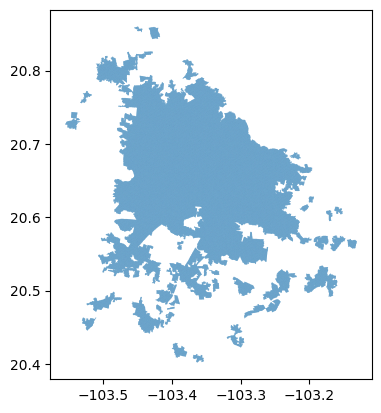

In [13]:
hex_gdf.loc[hex_gdf.city=='Guadalajara'].plot()

### Hexagon environmental data

In [15]:
schema = "raster_analysis"
env_var = ['ndvi','ndmi','temperature']
table = "analysis_hex"
c1 = 'Guadalajara'
c2 ='CDMX'
# res = 11

env_gdf = gpd.GeoDataFrame()

for evar in env_var:
    table_query = evar+'_'+table
    query = f'''
    SELECT 
        *
    FROM 
        {schema}.{table_query}
    WHERE 
        "city" IN ('{c1}', '{c2}')
        AND "res" = {res}
        AND "hex_id" IN {tuple(hex_gdf.hex_id.unique())}
    '''
    tmp_gdf = odc.gdf_from_query(query, geometry_col='geometry')

    if len(env_gdf) == 0:
        env_gdf = pd.concat([env_gdf,tmp_gdf])
    else:
        env_gdf = env_gdf.merge(tmp_gdf.drop(columns=['city','res','geometry']),
                               on='hex_id')
    del tmp_gdf

print(env_gdf.shape)
env_gdf.head(2)

(598071, 43)


,hex_id,geometry,res,ndvi_mean,ndvi_std,ndvi_median,ndvi_max,ndvi_min,ndvi_diff,ndvi_tend,...,temperature_max,temperature_min,temperature_diff,temperature_tend,temperature_2018,temperature_2019,temperature_2020,temperature_2021,temperature_2022,temperature_2023
0,8b4986492c02fff,"POLYGON ((-99.23013 19.23253, -99.22996 19.232...",11,0.349399,0.098564,0.352356,0.447373,0.252571,0.194802,-0.002467,...,42.395833,14.625000,27.770833,-0.039583,30.584821,32.53750,33.83750,31.156250,32.614583,25.340278
1,8b4986492c03fff,"POLYGON ((-99.23054 19.23281, -99.23036 19.233...",11,0.392806,0.128637,0.370856,0.535939,0.263467,0.272472,-0.003002,...,41.927083,14.398438,27.528646,-0.060937,30.410714,31.84375,33.31875,30.552083,32.114583,24.914931


In [16]:
env_gdf = env_gdf[~env_gdf['temperature_mean'].astype(float).isin([np.inf, -np.inf])]

for c in env_gdf.city.unique():
    env_gdf.loc[env_gdf.city==c,
    'temperature_mean_diff'] = env_gdf.loc[env_gdf.city==c,'temperature_mean'] - env_gdf.loc[env_gdf.city==c,'temperature_mean'].mean()

print(env_gdf.shape)
env_gdf.head(2)

(598071, 44)


,hex_id,geometry,res,ndvi_mean,ndvi_std,ndvi_median,ndvi_max,ndvi_min,ndvi_diff,ndvi_tend,...,temperature_min,temperature_diff,temperature_tend,temperature_2018,temperature_2019,temperature_2020,temperature_2021,temperature_2022,temperature_2023,temperature_mean_diff
0,8b4986492c02fff,"POLYGON ((-99.23013 19.23253, -99.22996 19.232...",11,0.349399,0.098564,0.352356,0.447373,0.252571,0.194802,-0.002467,...,14.625000,27.770833,-0.039583,30.584821,32.53750,33.83750,31.156250,32.614583,25.340278,-2.861870
1,8b4986492c03fff,"POLYGON ((-99.23054 19.23281, -99.23036 19.233...",11,0.392806,0.128637,0.370856,0.535939,0.263467,0.272472,-0.003002,...,14.398438,27.528646,-0.060937,30.410714,31.84375,33.31875,30.552083,32.114583,24.914931,-3.328564


### Population density by hexagon

In [20]:
schema = 'sociodemografico'
table = 'pobcenso_inegi_20_mzaageb_hex'
c1 = 'Guadalajara'
c2 ='CDMX'
socio_res = 9

query = f'''
        SELECT hex_id, city, dens_pob_ha, res, geometry
        FROM {schema}.{table}
        WHERE "city" IN ('{c1}', '{c2}')
        AND "res" = {socio_res}
        '''
socio_hex = odc.gdf_from_query(query)
print(socio_hex.shape)
socio_hex.head(2)

(13727, 5)


,hex_id,city,dens_pob_ha,res,geometry
0,894995bab23ffff,CDMX,113.531318,9,"POLYGON ((-99.20971 19.4807, -99.20847 19.4822..."
1,894995b8c0bffff,CDMX,192.690394,9,"POLYGON ((-99.1782 19.4842, -99.17696 19.48577..."


Density data to res 11 hexagons

In [21]:
hex_cnt = hex_gdf.copy()
hex_cnt = hex_cnt.to_crs("EPSG:6372")
hex_cnt['geometry'] = hex_cnt.centroid

In [23]:
socio_hex = socio_hex.to_crs("EPSG:6372")
hex_cnt = hex_cnt.overlay(socio_hex[['dens_pob_ha','geometry']])
print(hex_cnt.shape)
hex_cnt.head(5)

(596400, 5)


,hex_id,city,type,dens_pob_ha,geometry
0,8b498c960081fff,Guadalajara,urban,30.887770,POINT (2361392.815 959022.091)
1,8b49aa2d9936fff,Guadalajara,urban,4.192496,POINT (2362632.295 953246.003)
2,8b49aa2dd56efff,Guadalajara,urban,4.471807,POINT (2363250.883 951941.245)
3,8b49aa2d1048fff,Guadalajara,urban,72.056882,POINT (2366605.452 949315.893)
4,8b49aa2d8d08fff,Guadalajara,urban,0.000000,POINT (2365571.523 952067.809)


In [24]:
socio_hex = hex_gdf.merge(hex_cnt[['hex_id','dens_pob_ha']],
                         on='hex_id', how = 'left')
socio_hex = socio_hex.fillna(0)
print(socio_hex.shape)
socio_hex.head(5)

(598071, 5)


,hex_id,geometry,city,type,dens_pob_ha
0,8b498c960081fff,"POLYGON ((-103.33538 20.63189, -103.33521 20.6...",Guadalajara,urban,30.887770
1,8b49aa2d9936fff,"POLYGON ((-103.32293 20.57961, -103.32275 20.5...",Guadalajara,urban,4.192496
2,8b49aa2dd56efff,"POLYGON ((-103.31685 20.56782, -103.31668 20.5...",Guadalajara,urban,4.471807
3,8b49aa2d1048fff,"POLYGON ((-103.28432 20.54429, -103.28415 20.5...",Guadalajara,urban,72.056882
4,8b49aa2d8d08fff,"POLYGON ((-103.29452 20.56916, -103.29434 20.5...",Guadalajara,urban,0.000000


<Axes: >

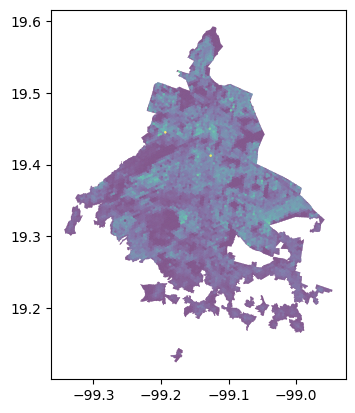

In [25]:
socio_hex.loc[socio_hex.city=='CDMX'].plot('dens_pob_ha')

In [26]:
del hex_cnt

## Public space hexagons

In [27]:
ep_gdf['area_ep_m2'] = ep_gdf.to_crs("EPSG:6372").area # total ep area
hex_gdf['area_hex_m2'] = hex_gdf.to_crs("EPSG:6372").area # total hex area

In [28]:
hex_ep = ep_gdf.overlay(hex_gdf, how='intersection')
hex_ep['area_ep_hex_m2'] = hex_ep.to_crs("EPSG:6372").area # ep area within each hex
# hex_ep['area_ep_pct_m2'] = hex_ep['area_ep_hex_m2'] / hex_ep['area_ep_m2'] # percentage of the original ep in the hex
print(hex_ep.shape)
hex_ep.head(2)

(43305, 9)


,Tipo,subcat_sed,area_ep_m2,hex_id,city,type,area_hex_m2,geometry,area_ep_hex_m2
0,Parque,Deportivos,365.225397,8b49aa2582c4fff,Guadalajara,urban,2524.473099,"POLYGON ((-103.46694 20.51885, -103.46702 20.5...",2.905512
1,Parque,Deportivos,365.225397,8b49aa2582c0fff,Guadalajara,urban,2524.475151,"POLYGON ((-103.46679 20.51919, -103.46677 20.5...",360.568997


In [30]:
tmp_gdf = hex_ep[['hex_id',
                  'area_ep_hex_m2']].groupby('hex_id').sum().reset_index()
hex_ep = hex_ep.drop_duplicates(subset='hex_id')
hex_ep = pd.merge(tmp_gdf, hex_ep[['hex_id','area_hex_m2']],
                        how='left')
hex_ep['area_ephex_pct_m2'] = hex_ep['area_ep_hex_m2'] / hex_ep['area_hex_m2'] # percetage of ep within each hex
print(hex_ep.shape)
hex_ep.head(5)

(40415, 4)


,hex_id,area_ep_hex_m2,area_hex_m2,area_ephex_pct_m2
0,8b498c905932fff,541.667109,2522.067233,0.214771
1,8b498c905936fff,1093.420189,2522.065229,0.433542
2,8b498c908242fff,263.223179,2522.700133,0.104342
3,8b498c908244fff,349.307397,2522.701804,0.138466
4,8b498c908246fff,1410.407816,2522.698159,0.559087


<Axes: >

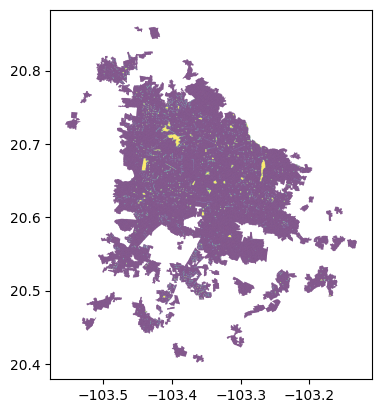

In [31]:
hex_gdf.loc[hex_gdf.city=='Guadalajara'].merge(hex_ep, 
              on='hex_id', how='left').fillna(0).plot('area_ephex_pct_m2')

In [32]:
hex_ep = hex_gdf[['hex_id']].merge(hex_ep, 
              on='hex_id', how='left').fillna(0)
print(hex_ep.shape)
hex_ep.head(2)

(598071, 4)


,hex_id,area_ep_hex_m2,area_hex_m2,area_ephex_pct_m2
0,8b498c960081fff,0.0,0.0,0.0
1,8b49aa2d9936fff,0.0,0.0,0.0


## Model variables to hexagons

In [33]:
hex_var = hex_gdf[['hex_id']].merge(hex_ep[['hex_id','area_ephex_pct_m2']])

hex_var = hex_var.merge(env_gdf[['hex_id','ndvi_mean',
                                 'temperature_mean_diff','ndmi_diff']],
                       on='hex_id')

hex_var = hex_var.merge(socio_hex[['hex_id','dens_pob_ha']],
                       on='hex_id')

print(hex_var.shape)
hex_var.head(4)

(598071, 6)


,hex_id,area_ephex_pct_m2,ndvi_mean,temperature_mean_diff,ndmi_diff,dens_pob_ha
0,8b498c960081fff,0.0,0.108520,1.180688,0.036202,30.887770
1,8b49aa2d9936fff,0.0,0.457420,-5.850713,0.272936,4.192496
2,8b49aa2dd56efff,0.0,0.096807,4.238918,0.083546,4.471807
3,8b49aa2d1048fff,0.0,0.206603,-0.309995,0.106166,72.056882


### Additional variables

Possible additional variables: marginalization index, proximity analysis, sip data,

## Dummy variable

1 = hexagon with equal or greater than 30% of public space
0 = hexagon with more less than 30% of public space

In [34]:
hex_var['ep_id'] = 0

In [36]:
hex_var.loc[hex_var.area_ephex_pct_m2>=0.25, 'ep_id'] = 1

hex_var.ep_id = hex_var.ep_id.astype(int)

In [37]:
len(hex_var.loc[hex_var.ep_id==1])

33476

In [38]:
len(hex_var.loc[hex_var.ep_id==0])

564595

## Exploratory data analysis

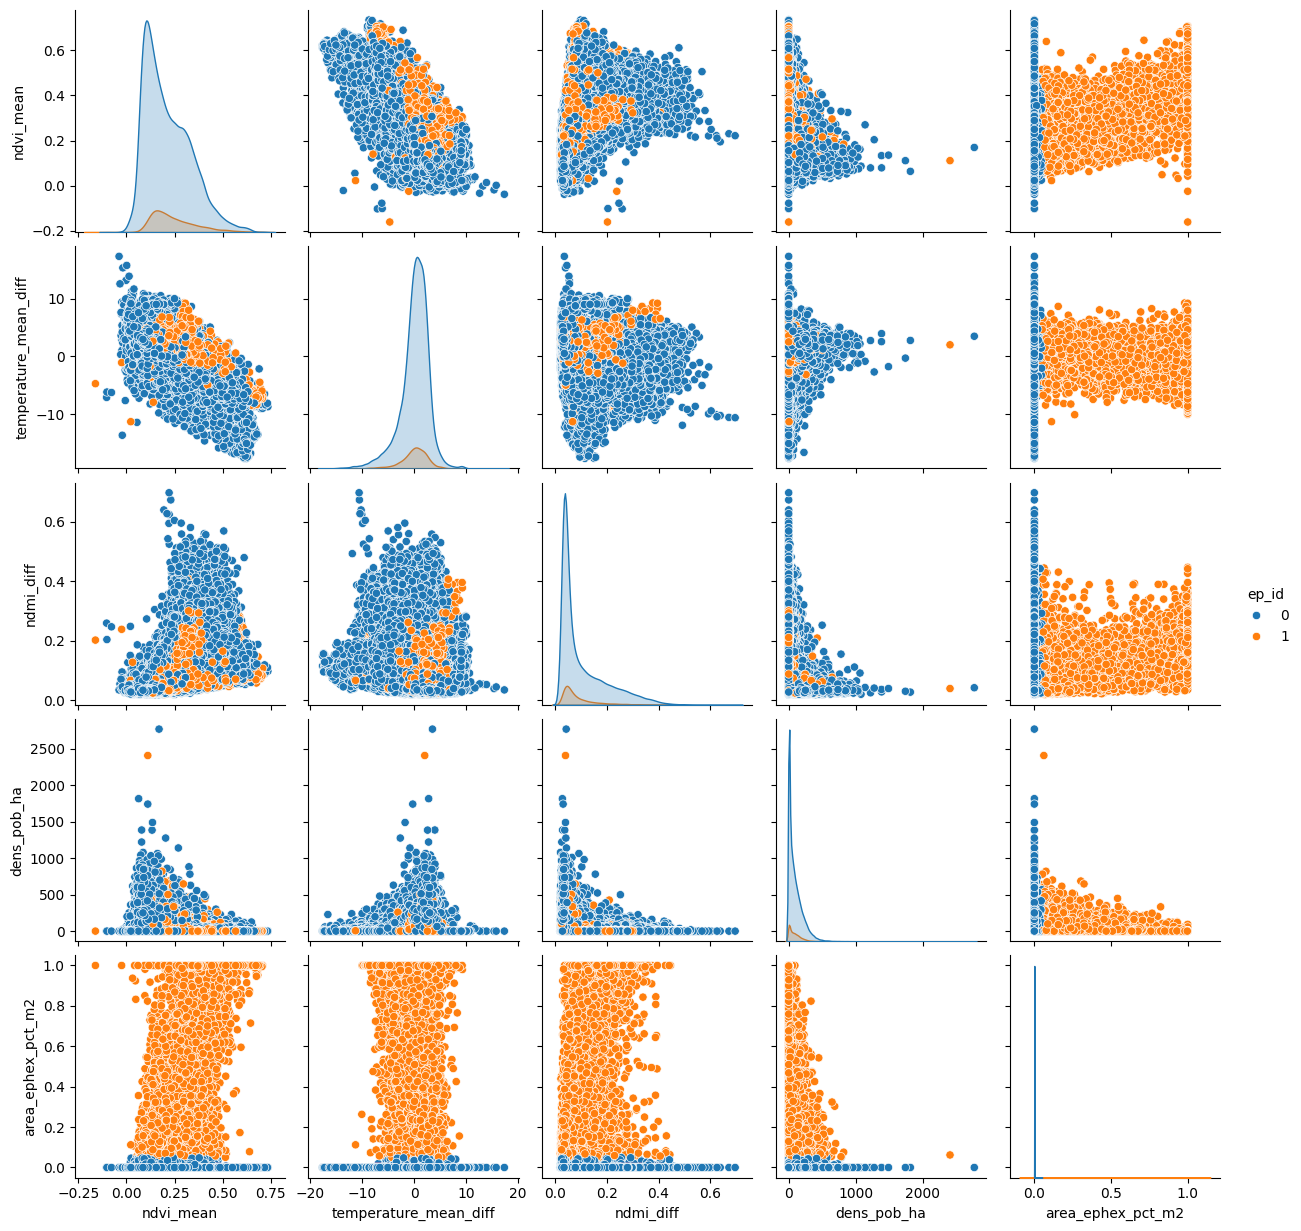

In [25]:
sns.pairplot(hex_var[['ndvi_mean','temperature_mean_diff',
                     'ndmi_diff','dens_pob_ha','area_ephex_pct_m2','ep_id']],
             hue='ep_id'
             )

## Model development

### Variable preprocessing

In [39]:
X = np.array(hex_var[['ndvi_mean','temperature_mean_diff',
                     'ndmi_diff','dens_pob_ha']])
Y = np.array(hex_var['ep_id'])

In [40]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [41]:
x_train, x_test, y_train, y_test = train_test_split(X_scaled, Y,
                                                    test_size=0.45, random_state = 42)

In [42]:
x_train.shape

(328939, 4)

#### Oversampling

In [45]:
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(x_train, y_train)

In [46]:
print(X_resampled.shape, x_train.shape)

(621332, 4) (328939, 4)


### Logistic regression

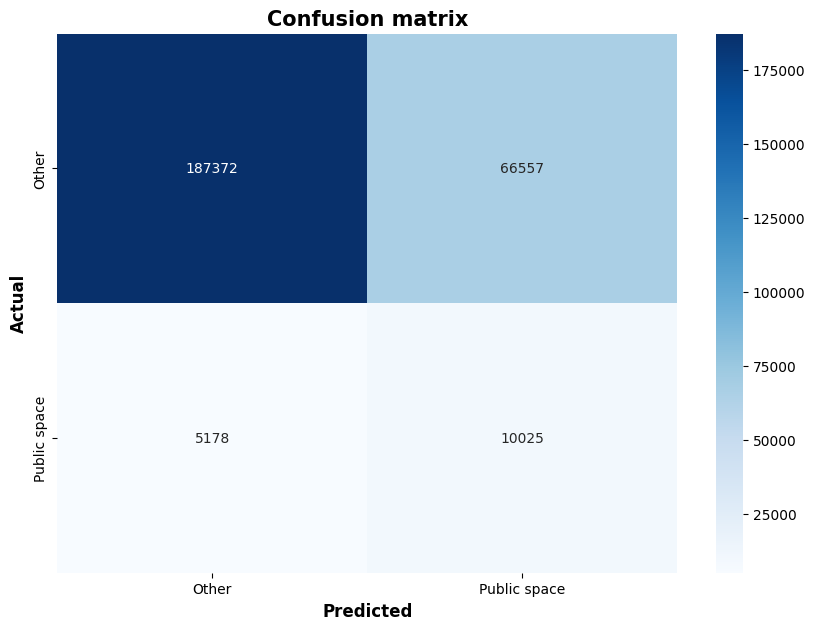

In [62]:
model = LogisticRegression(max_iter=10000, C=1, penalty='l2', solver='sag', warm_start=True)
model.fit(x_train, y_train)

y_pred = clf.predict(x_test)

#Generar matriz de confusión:
cm2 = confusion_matrix(y_test, y_pred)
class_labels = ['Other', 'Public space']

plt.figure(figsize=(10, 7))
sns.heatmap(cm2, annot=True, fmt="g", cmap="Blues", 
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted', fontsize=12, fontweight='bold')
plt.ylabel('Actual', fontsize=12, fontweight='bold')
plt.title('Confusion matrix', fontsize=15, fontweight='bold')
plt.show()

In [63]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.7334579314239853


In [64]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.74      0.84    253929
           1       0.13      0.66      0.22     15203

    accuracy                           0.73    269132
   macro avg       0.55      0.70      0.53    269132
weighted avg       0.93      0.73      0.80    269132



### XBGClassifier

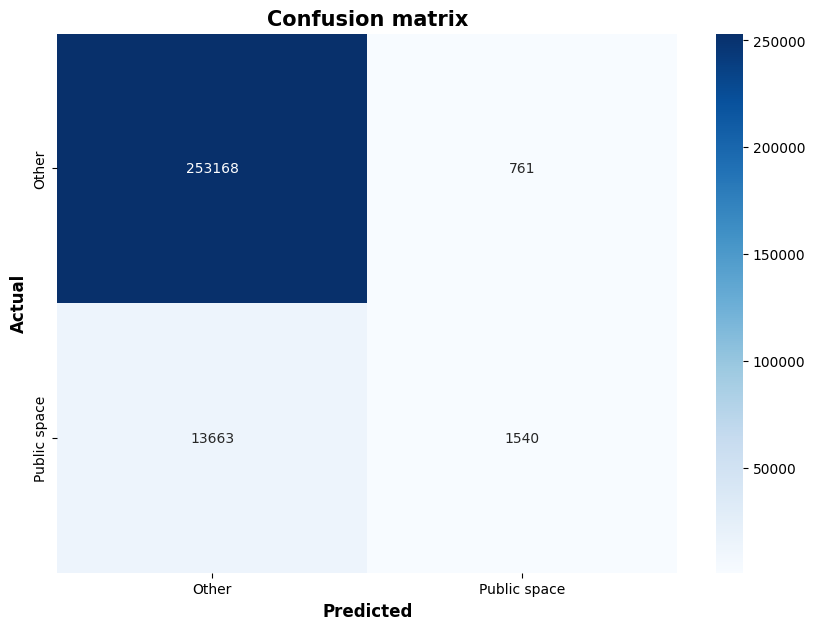

In [68]:
model = xgb.XGBClassifier( 
                      eval_metric='logloss',
                    n_estimators=300,       # Number of boosting rounds
                    learning_rate=0.1,      # Step size shrinkage
                    max_depth=10,            # Maximum tree depth
                    min_child_weight=1,     # Minimum sum of instance weight needed in a child
                    gamma=0,                # Minimum loss reduction required to make a further partition
                    subsample=0.8,          # Subsample ratio of the training instances
                    colsample_bytree=0.8,   # Subsample ratio of columns when constructing each tree
                    objective='binary:logistic',  # Specify the learning task
                    random_state=42          # For reproducibility
                )
model.fit(x_train, y_train)

y_pred = model.predict(x_test)

#Generar matriz de confusión:
cm2 = confusion_matrix(y_test, y_pred)
class_labels = ['Other', 'Public space']

plt.figure(figsize=(10, 7))
sns.heatmap(cm2, annot=True, fmt="g", cmap="Blues", 
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted', fontsize=12, fontweight='bold')
plt.ylabel('Actual', fontsize=12, fontweight='bold')
plt.title('Confusion matrix', fontsize=15, fontweight='bold')
plt.show()

In [69]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.946405481325149


In [70]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97    253929
           1       0.67      0.10      0.18     15203

    accuracy                           0.95    269132
   macro avg       0.81      0.55      0.57    269132
weighted avg       0.93      0.95      0.93    269132



### Naive Bayes

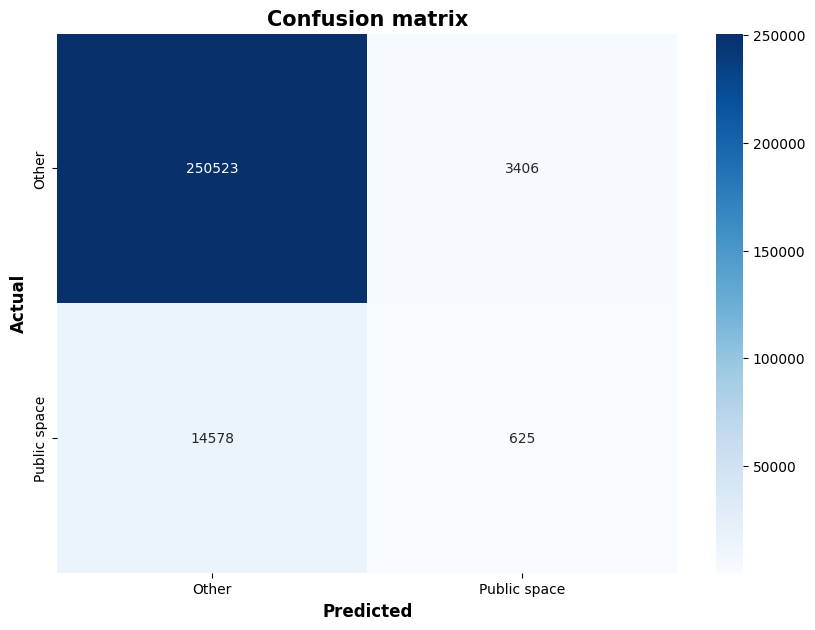

In [71]:
model = GaussianNB()

model.fit(x_train, y_train)

y_pred = model.predict(x_test)

#Generar matriz de confusión:
cm2 = confusion_matrix(y_test, y_pred)
class_labels = ['Other', 'Public space']

plt.figure(figsize=(10, 7))
sns.heatmap(cm2, annot=True, fmt="g", cmap="Blues", 
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted', fontsize=12, fontweight='bold')
plt.ylabel('Actual', fontsize=12, fontweight='bold')
plt.title('Confusion matrix', fontsize=15, fontweight='bold')
plt.show()

In [72]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.9331777715024597


In [73]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97    253929
           1       0.16      0.04      0.06     15203

    accuracy                           0.93    269132
   macro avg       0.55      0.51      0.52    269132
weighted avg       0.90      0.93      0.91    269132



### AdaBoostClassifier

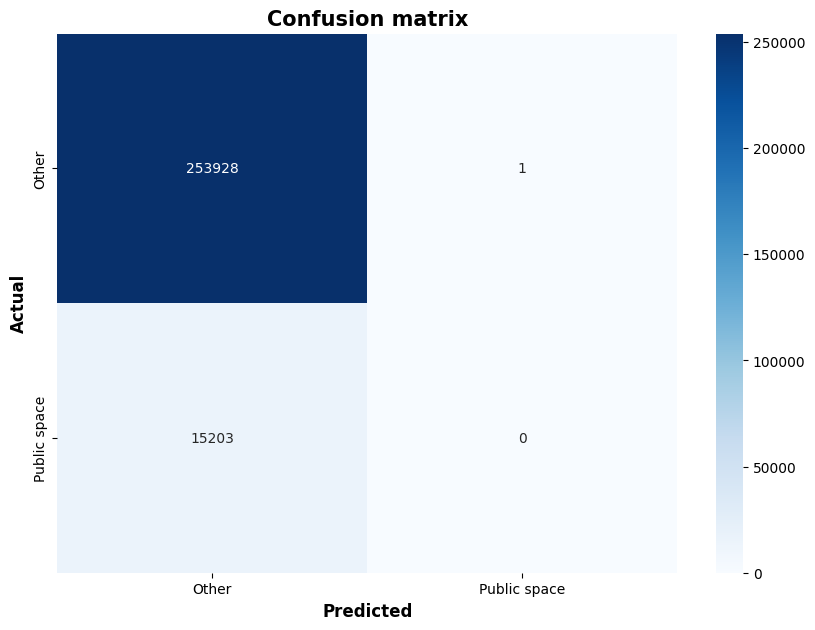

In [74]:
model = AdaBoostClassifier(n_estimators = 100)

model.fit(x_train, y_train)

y_pred = model.predict(x_test)

#Generar matriz de confusión:
cm2 = confusion_matrix(y_test, y_pred)
class_labels = ['Other', 'Public space']

plt.figure(figsize=(10, 7))
sns.heatmap(cm2, annot=True, fmt="g", cmap="Blues", 
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted', fontsize=12, fontweight='bold')
plt.ylabel('Actual', fontsize=12, fontweight='bold')
plt.title('Confusion matrix', fontsize=15, fontweight='bold')
plt.show()

In [75]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.9435072752404025


In [76]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97    253929
           1       0.00      0.00      0.00     15203

    accuracy                           0.94    269132
   macro avg       0.47      0.50      0.49    269132
weighted avg       0.89      0.94      0.92    269132



### Random Forest Classifier

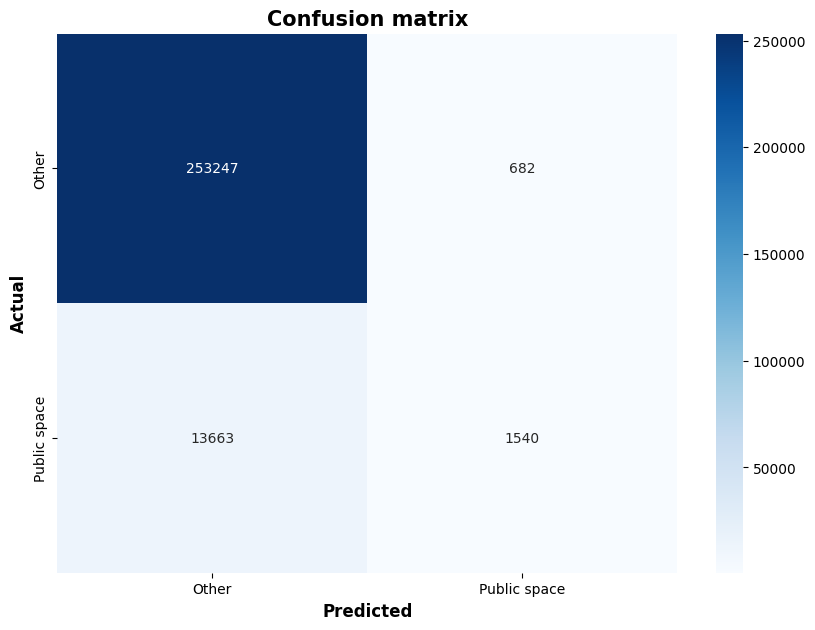

In [77]:
model = RandomForestClassifier(n_estimators=120, random_state=42)  

model.fit(x_train, y_train)

y_pred = model.predict(x_test)

#Generar matriz de confusión:
cm2 = confusion_matrix(y_test, y_pred)
class_labels = ['Other', 'Public space']

plt.figure(figsize=(10, 7))
sns.heatmap(cm2, annot=True, fmt="g", cmap="Blues", 
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted', fontsize=12, fontweight='bold')
plt.ylabel('Actual', fontsize=12, fontweight='bold')
plt.title('Confusion matrix', fontsize=15, fontweight='bold')
plt.show()

In [78]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.9466990175824502


In [79]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97    253929
           1       0.69      0.10      0.18     15203

    accuracy                           0.95    269132
   macro avg       0.82      0.55      0.57    269132
weighted avg       0.93      0.95      0.93    269132



### Neural network

In [52]:
# create model
model = Sequential()
model.add(Dense(10, input_dim =4, activation='relu'))
model.add(Dense(8, activation='softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

NameError: name 'Sequential' is not defined